### Joseph EL KETTANEH - M1 SD
## TP2 Apprentissage Automatique 2 
## Régression logistique

In [2]:
import numpy as np
import pandas as pd

#Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt

#To plot the graph embedded in the notebook
%matplotlib inline
import sklearn.datasets
from IPython.display import Image

from sklearn import datasets
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from numpy.linalg import norm

# Accuracy 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import warnings
warnings.filterwarnings('ignore')

## 1 - Problème jouet

    Génération de base de données synthétiques telle que :
        ◦ chaque classe contient 300 points
        ◦ λ1 ∼ N((1,1),0.7) et λ2 ∼ N((−1,−1),0.7)

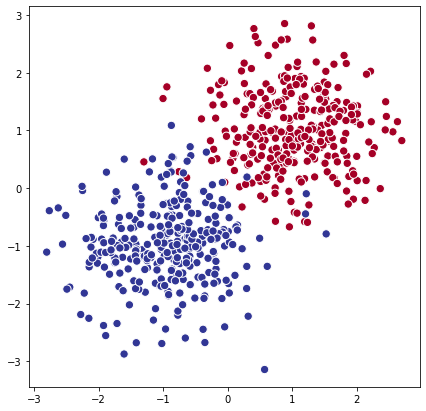

In [3]:
# we create two clusters of random points
n_samples_1 = 300
n_samples_2 = 300
centers = [[1, 1], [-1, -1]]
clusters_std = [0.7, 0.7]
X, y = make_blobs(
    n_samples=[n_samples_1, n_samples_2],
    centers=centers,
    cluster_std=clusters_std,
    random_state=5,
    shuffle=False,
)
plt.subplots(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y,cmap='RdYlBu', edgecolor="white", linewidth=1 , s=70)

   ### 1 - Classification sur la base synthétique en utilisant le modèle de régression logistique de scikit-learn

In [4]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=0)
classifier.fit(X, y)

LogisticRegression(random_state=0)

In [5]:
def mesh(X, h = 0.02):
    x_min , x_max = X.iloc[:, 0].min() - .5, X.iloc[:, 0].max() + .5
    y_min , y_max = X.iloc[:, 1].min() - .5, X.iloc[:, 1].max() + .5
    xx , yy = np.meshgrid(np.arange(x_min , x_max , h), np.arange(y_min , y_max , h))
    return np.c_[xx.ravel(), yy.ravel()], xx , yy

In [6]:
df = pd.DataFrame(X)
grid,xx,yy=mesh(df,0.02)
probs = classifier.predict_proba(grid)[:, 1].reshape(xx.shape)

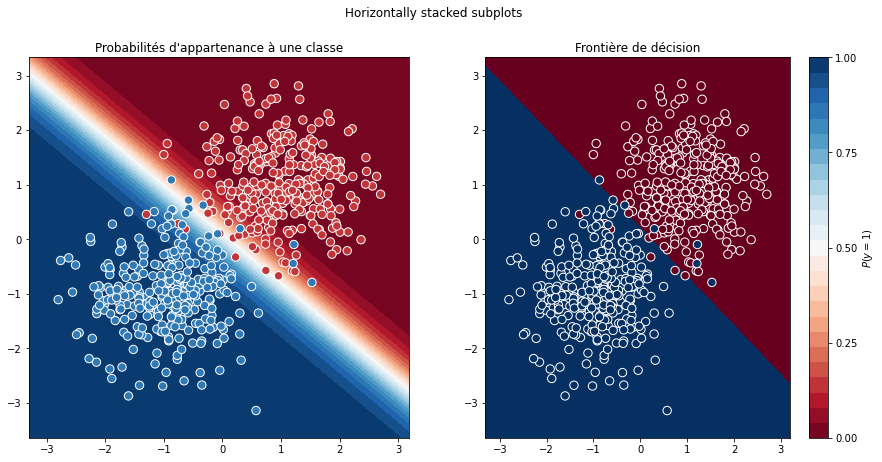

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 7))
fig.suptitle('Horizontally stacked subplots')

contour = ax1.contourf(xx, yy, probs, 25, cmap="RdBu",vmin=0, vmax=1)
ax_c = fig.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])
ax1.set_title("Probabilités d'appartenance à une classe")
ax1.scatter(X[:, 0], X[:, 1], c=y, s=70,cmap="RdBu", vmin=-.2, vmax=1.2, edgecolor="white", linewidth=1)

ax2.set_title("Frontière de décision")
ax2.contourf(xx, yy, probs, levels=2, cmap="RdBu", vmin=0.2, vmax=0.6)
ax2.scatter(X[:, 0], X[:, 1], c=y, s=70,cmap="RdBu", edgecolor="white", linewidth=1)

    La première figure représente la marge de décision par probabilités, nous pouvons voir que les points sur la région blanche ont une probabilité d'appartenir à la classe 1 de 0.5 ; ceci indique que nous sommes sur la région d'indécision, plus les couleurs sont foncées plus la probabilité d'appartenir à la classe qui correspond à cette couleur est élevée.
    En comparant avec la classe bleue (y = 1), nous voyons que les points qui se trouvent sur la marge rouge clair ont une faible probabilité d'appartenir à la classe bleue (par exemple 0,25 pour le rouge clair), mais au fur et à mesure que nous nous éloignons du rouge et que nous nous rapprochons du bleu, la probabilité d'appartenir à la classe (y=1) augmente (par exemple 0,75 pour le bleu clair).

    La deuxième figure représente le frontière de décision utilisée pendant la prédiction du modèle, nous pouvons clairement voir que le modèle a fait quelques erreurs de prédiction car il y a des points rouges dans la région bleue et vice versa.

## 2 - Régression logistique sur le problème jouet

##### Ma mise en œuvre du modèle de régression logistique

In [8]:
def sigmoid(z):
    y_head = 1/(1+np.exp(-z))
    return y_head

def matrice_augmente(X):
    vect_ones = np.ones((X.shape[0], 1))
    return np.concatenate((vect_ones, X), axis=1)

def logreg_cost(y, z):
    return np.sum(y*z) + np.sum(np.log(1 + np.exp(-z)))

def predict_probs(X,w):
    X = matrice_augmente(X)
    return sigmoid(np.dot(X, w))
    #return np.dot(X, w)

def predict(X,W):
    return predict_probs(X,W).round()

def logreg_grad_desc(X, y, n_iter=10000, pas=0.001):
    
    X = matrice_augmente(X)
    W = np.zeros(X.shape[1])
    cost_list = []
    
    for i in range(n_iter):
        z = np.dot(X, W)
        #gradient = np.dot(X.T,y-(np.exp(-z)/1+np.exp(-z)))
        h = sigmoid(z)
        gradient = np.dot(X.T, (h - y)) / y.size
        W -= pas * gradient    
        if(i % 1500 == 0):       
            cost = logreg_cost(y,z)
            cost_list.append(cost)
        
    return W, cost_list

    Phase d'apprentissage des données en mettant a jour w en optimizant le cost

In [9]:
w, cost = logreg_grad_desc(X, y)

    Phase de prediction et extraction des probabilités d'appartenance à une classe

In [10]:
y_pred = predict(X,w)
y_prob = predict_probs(X,w)

    Phase d'Affichage de la fonction de décision 

In [11]:
def hypothesis(theta, X, n):
    h = np.ones((X.shape[0],1))
    theta = theta.reshape(1,n+1)
    for i in range(0,X.shape[0]):
        h[i] = 1 / (1 + np.exp(-float(np.matmul(theta, X[i]))))
    h = h.reshape(X.shape[0])
    return h

def plot_desc(X,y, W, xx1,yy1):
    
    theta = W.reshape(3)
    # getting the x co-ordinates of the decision boundary
    plot_x = np.array([min(X[:,0]), max(X[:,0])])
    # getting corresponding y co-ordinates of the decision boundary
    plot_y = (-1/theta[2]) * (theta[1] * plot_x + theta[0])
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20, 10))
    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, .25, .5, .75, 1])
    ax1.scatter(X[:,0], X[:,1],c=y, cmap="RdBu", edgecolor="white", linewidth=1 , s=70)
    ax1.set_title("Fonction de décision")
    ax1.plot(plot_x, plot_y, label = "Fonction de décision ")
    ax1.legend()
    
    X1 = np.concatenate((np.ones((xx1.shape[0]*xx1.shape[1],1)),  np.c_[xx1.ravel(), yy1.ravel()]), axis = 1)
    h = hypothesis(w, X1, 2)
    h = h.reshape(xx1.shape)
    ax2.set_title("Probabilités d'appartenance à une classe")
    ax2.contourf(xx1, yy1, h, cmap="RdBu")
    ax2.scatter(X[:, 0], X[:, 1], c=y, edgecolor='white', cmap="RdBu", s=70, linewidth=1)



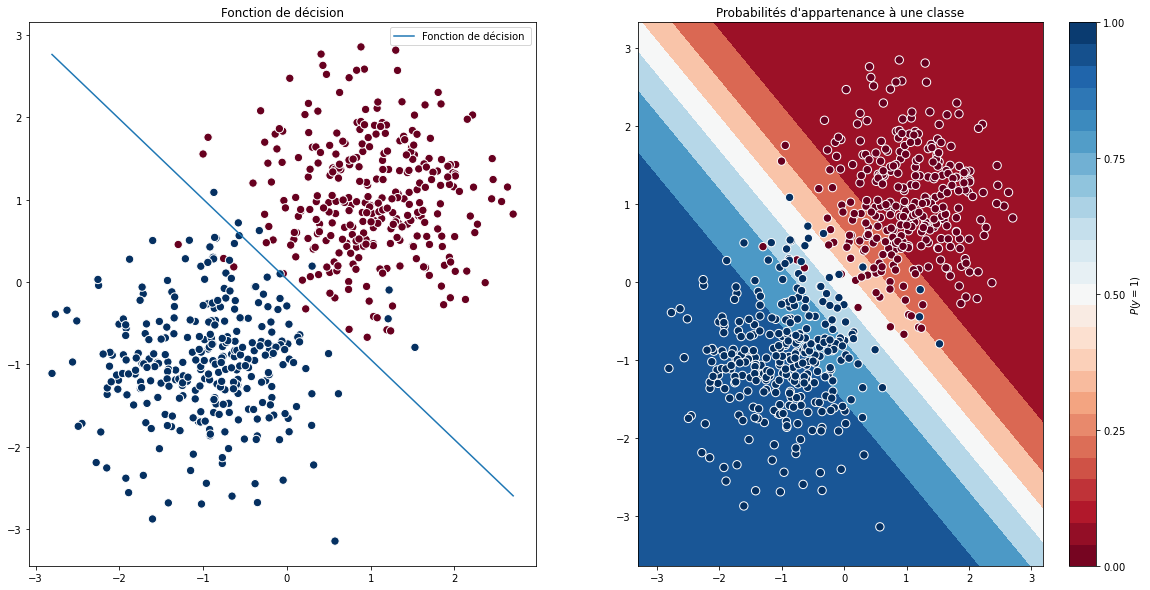

In [12]:
plot_desc(X,y,w,xx,yy)

    La première figure représente la frontière de décision utilisée lors de la prédiction du modèle, nous pouvons clairement voir que mon modèle de régression logistique a fait quelques erreurs de prédiction car il y a des points rouges dans la région en dessous de la fonction de décision qui sont classés dans la classe bleue (y=1) et il y a des points bleus qui sont au-dessus de la fonction de décision qui sont classés dans la classe rouge (y=0).
    
    La deuxième figure représente la marge de décision par probabilités, nous pouvons voir que les points sur la région blanche ont une probabilité d'appartenir à la classe 1 de 0.5 ; ceci indique que nous sommes sur la région d'indécision, plus les couleurs sont foncées plus la probabilité d'appartenir à la classe qui correspond à cette couleur est élevée.
    En comparant avec la classe bleue (y = 1), nous voyons que les points qui se trouvent sur la marge rouge clair ont une faible probabilité d'appartenir à la classe bleue (par exemple 0,25 pour le rouge clair), mais au fur et à mesure que nous nous éloignons du rouge et que nous nous rapprochons du bleu, la probabilité d'appartenir à la classe (y=1) augmente (par exemple 0,75 pour le bleu clair).



    Test de performance de mon modèle de regression logistique

In [14]:
def taux_bonne_classi(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [15]:
my_score = taux_bonne_classi(y,y_pred )
print("Le taux de precision de mon modele en Aprentissage = ", my_score)

Le taux de precision de mon modele en Aprentissage =  98.16666666666667


## 3 - Diagnostique médical

In [164]:
import sklearn.datasets as dataset
data = dataset.load_breast_cancer()
x1 = data.data
y1 = data.target

In [165]:
    x_train, x_test, y_train, y_test = train_test_split(x1, y1, test_size=0.3, random_state=42)

##### Apprentissage et prediction en utilisant mon modéle de regression logistique

In [166]:
w_cancer, cost_cancer = logreg_grad_desc(x_train, y_train, n_iter=10000, pas=0.01)
ypred_mon_modele = predict(x_test,w_cancer)

##### Apprentissage et prediction en utilisant le modèle de regression logistique de Scikit-learn par defaut

In [167]:
classifier = LogisticRegression(random_state=0)
classifier.fit(x_train, y_train)
ypred_scikit = classifier.predict(x_test)

##### Apprentissage et prediction en utilisant un  modèle regression logistique régularisée

In [168]:
clf_regularise = LogisticRegression(
    penalty="l1",
    C = 100, 
    solver="liblinear",
    tol=1e-6,
    max_iter=int(1e6),
    warm_start=True,
    intercept_scaling=10000.0,
)
clf_regularise.fit(x_train, y_train)
ypred_scikit_regul = clf_regularise.predict(x_test)

#### Mon modèle   VS   Scikit-learn   VS    modèle Scikit-learn régularisée

In [169]:
from tabulate import tabulate

In [172]:
# taux de precision en test
my_score = taux_bonne_classi(y_test,ypred_mon_modele)
sci_score = taux_bonne_classi(y_test,ypred_scikit)
sci_reg_score = taux_bonne_classi(y_test,ypred_scikit_regul)

# Ecart-type de prediction
my_pred_variance = (ypred_mon_modele == y_test).std()
sci_pred_variance = (ypred_scikit == y_test).std()
sci_regul_pred_variance = (ypred_scikit_regul == y_test).std()



##### Résultats de la comparaison de 3 implémentations de la régression logistique

In [173]:
print(tabulate({ 'Modèles': ['Mon Modèle', 'Scikit-learn', 'Logistique Régularisée']
                , 'Taux de precision en Test': [str(my_score)+'%', str(sci_score)+'%', str(sci_reg_score)+'%']
                , 'Ecart-type': [my_pred_variance, sci_pred_variance, sci_regul_pred_variance]
                , 'rang': ['3','2','1']}
               , headers="keys"
               #, title = "Résultats de la comparaison de 3 implémentations de la régression logistique"
               , tablefmt='fancy_grid'
               , missingval=''))

╒════════════════════════╤═════════════════════════════╤══════════════╤════════╕
│ Modèles                │ Taux de precision en Test   │   Ecart-type │   rang │
╞════════════════════════╪═════════════════════════════╪══════════════╪════════╡
│ Mon Modèle             │ 92.39766081871345%          │     0.265036 │      3 │
├────────────────────────┼─────────────────────────────┼──────────────┼────────┤
│ Scikit-learn           │ 97.07602339181285%          │     0.168478 │      2 │
├────────────────────────┼─────────────────────────────┼──────────────┼────────┤
│ Logistique Régularisée │ 97.6608187134503%           │     0.151144 │      1 │
╘════════════════════════╧═════════════════════════════╧══════════════╧════════╛


    En comparant les 3 modèles de régression logistique, mon implémentation VS la fonction scikit-learn avec les hyperparamètres par défaut VS la fonction scikit-learn régularisée, nous avons obtenu les résultats affichés dans le tableau ci-dessus. 
    Mon modèle a donné l'écart type le plus élevé, les prédictions sont donc plus éloignées de la moyenne par rapport aux 2 autres algorithmes. Le taux de précision de mon algo est également plus faible que celui des 2 autres algos.
    Nous pouvons voir que le modèle régularisé de Scikit-learn a un meilleur taux de précision et un écart-type plus faible, ce qui indique que les prédictions sont plus proches de leur classification réelle.

### Expérimentations en ’jouant’ avec les autres paramètres de l’algorithme de Scikit-learn

In [175]:
from sklearn.model_selection import GridSearchCV

LR = LogisticRegression()
LRparam_grid = {
    'C' : [1000,100,10, 1, .5, .1, .01, .001,.0001],
    'penalty': ['l1', 'l2'],
    # 'max_iter': list(range(100,800,100)),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'tol' : [0.01]
}
LR_search = GridSearchCV(LR, param_grid=LRparam_grid, refit = True, verbose = 3, cv=5 )

# fitting the model for grid search 
LR_search.fit(x_train , y_train)
LR_search.best_params_
# summarize
print('Mean Accuracy: %.3f' % LR_search.best_score_)
print('Config: %s' % LR_search.best_params_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV 1/5] END .C=1000, penalty=l1, solver=newton-cg, tol=0.01; total time=   0.0s
[CV 2/5] END .C=1000, penalty=l1, solver=newton-cg, tol=0.01; total time=   0.0s
[CV 3/5] END .C=1000, penalty=l1, solver=newton-cg, tol=0.01; total time=   0.0s
[CV 4/5] END .C=1000, penalty=l1, solver=newton-cg, tol=0.01; total time=   0.0s
[CV 5/5] END .C=1000, penalty=l1, solver=newton-cg, tol=0.01; total time=   0.0s
[CV 1/5] END .....C=1000, penalty=l1, solver=lbfgs, tol=0.01; total time=   0.0s
[CV 2/5] END .....C=1000, penalty=l1, solver=lbfgs, tol=0.01; total time=   0.0s
[CV 3/5] END .....C=1000, penalty=l1, solver=lbfgs, tol=0.01; total time=   0.0s
[CV 4/5] END .....C=1000, penalty=l1, solver=lbfgs, tol=0.01; total time=   0.0s
[CV 5/5] END .....C=1000, penalty=l1, solver=lbfgs, tol=0.01; total time=   0.0s
[CV 1/5] END .C=1000, penalty=l1, solver=liblinear, tol=0.01; total time=   0.0s
[CV 2/5] END .C=1000, penalty=l1, solver=liblin

[CV 3/5] END ...C=10, penalty=l2, solver=newton-cg, tol=0.01; total time=   0.0s
[CV 4/5] END ...C=10, penalty=l2, solver=newton-cg, tol=0.01; total time=   0.0s
[CV 5/5] END ...C=10, penalty=l2, solver=newton-cg, tol=0.01; total time=   0.0s
[CV 1/5] END .......C=10, penalty=l2, solver=lbfgs, tol=0.01; total time=   0.0s
[CV 2/5] END .......C=10, penalty=l2, solver=lbfgs, tol=0.01; total time=   0.0s
[CV 3/5] END .......C=10, penalty=l2, solver=lbfgs, tol=0.01; total time=   0.0s
[CV 4/5] END .......C=10, penalty=l2, solver=lbfgs, tol=0.01; total time=   0.0s
[CV 5/5] END .......C=10, penalty=l2, solver=lbfgs, tol=0.01; total time=   0.0s
[CV 1/5] END ...C=10, penalty=l2, solver=liblinear, tol=0.01; total time=   0.0s
[CV 2/5] END ...C=10, penalty=l2, solver=liblinear, tol=0.01; total time=   0.0s
[CV 3/5] END ...C=10, penalty=l2, solver=liblinear, tol=0.01; total time=   0.0s
[CV 4/5] END ...C=10, penalty=l2, solver=liblinear, tol=0.01; total time=   0.0s
[CV 5/5] END ...C=10, penalt

[CV 5/5] END ..C=0.5, penalty=l2, solver=newton-cg, tol=0.01; total time=   0.0s
[CV 1/5] END ......C=0.5, penalty=l2, solver=lbfgs, tol=0.01; total time=   0.0s
[CV 2/5] END ......C=0.5, penalty=l2, solver=lbfgs, tol=0.01; total time=   0.0s
[CV 3/5] END ......C=0.5, penalty=l2, solver=lbfgs, tol=0.01; total time=   0.0s
[CV 4/5] END ......C=0.5, penalty=l2, solver=lbfgs, tol=0.01; total time=   0.0s
[CV 5/5] END ......C=0.5, penalty=l2, solver=lbfgs, tol=0.01; total time=   0.0s
[CV 1/5] END ..C=0.5, penalty=l2, solver=liblinear, tol=0.01; total time=   0.0s
[CV 2/5] END ..C=0.5, penalty=l2, solver=liblinear, tol=0.01; total time=   0.0s
[CV 3/5] END ..C=0.5, penalty=l2, solver=liblinear, tol=0.01; total time=   0.0s
[CV 4/5] END ..C=0.5, penalty=l2, solver=liblinear, tol=0.01; total time=   0.0s
[CV 5/5] END ..C=0.5, penalty=l2, solver=liblinear, tol=0.01; total time=   0.0s
[CV 1/5] END ........C=0.5, penalty=l2, solver=sag, tol=0.01; total time=   0.0s
[CV 2/5] END ........C=0.5, 

[CV 5/5] END .....C=0.001, penalty=l1, solver=saga, tol=0.01; total time=   0.0s
[CV 1/5] END C=0.001, penalty=l2, solver=newton-cg, tol=0.01; total time=   0.0s
[CV 2/5] END C=0.001, penalty=l2, solver=newton-cg, tol=0.01; total time=   0.0s
[CV 3/5] END C=0.001, penalty=l2, solver=newton-cg, tol=0.01; total time=   0.0s
[CV 4/5] END C=0.001, penalty=l2, solver=newton-cg, tol=0.01; total time=   0.0s
[CV 5/5] END C=0.001, penalty=l2, solver=newton-cg, tol=0.01; total time=   0.0s
[CV 1/5] END ....C=0.001, penalty=l2, solver=lbfgs, tol=0.01; total time=   0.0s
[CV 2/5] END ....C=0.001, penalty=l2, solver=lbfgs, tol=0.01; total time=   0.0s
[CV 3/5] END ....C=0.001, penalty=l2, solver=lbfgs, tol=0.01; total time=   0.0s
[CV 4/5] END ....C=0.001, penalty=l2, solver=lbfgs, tol=0.01; total time=   0.0s
[CV 5/5] END ....C=0.001, penalty=l2, solver=lbfgs, tol=0.01; total time=   0.0s
[CV 1/5] END C=0.001, penalty=l2, solver=liblinear, tol=0.01; total time=   0.0s
[CV 2/5] END C=0.001, penalt

##### en conlusion

    En evaluant le grid search des meilleurs parametres en apprentissage j'ai preciser des differentes parametres des resularisation pour C ([1000,100,10, 1, .5, .1, .01, .001,.0001]) aussi pour la pinalite ('l1','l2') et pour 5 differents solver ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')
    
    En permuttant toutes ces valeurs en utilisant les donnees d'Apprentissage j'ai eu les meilleurs resultats pour les hyperparametres suivantes:
    
        ◦ C = 100
        ◦ Penalite = l1
        ◦ solver = liblinear
        ◦ tol = 0.01
    

##### En essayant ces paramètres sur les données test

In [192]:
best_logreg = LogisticRegression(penalty='l1', C=100, tol=0.01, solver='liblinear')
best_logreg.fit(x_train, y_train)
ypred_best_logreg = best_logreg.predict(x_test)
best_logreg_score = taux_bonne_classi(y_test,ypred_best_logreg)
print("Le Taux de bonne classification = ", best_logreg_score)

Le Taux de bonne classification =  97.6608187134503
